# Script IDF

# Librairies

In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import scipy.optimize
from functools import partial
from DL_Data import DL_Data
import lmoments3 as lm
import lmoments3.distr as lmdist

# Données et traitement: Peak-over-treshold

Extraction des données: utiliser num_sta pour choisir la station d'intérêt et modifier le chemin vers les données si nécessaire

In [ ]:
Station = ['Aigle','Dole','Payerne','Fretaz','Pully','Nyon','Moleson','Zermatt','Adelboden']
num_sta = 6

Path = "../Database/Precipitations"
df = DL_Data(Path, Station[num_sta])

print('\nDonnées sélectionnées: \n\n\tStation: '+Station[num_sta])


Données sélectionnées: 

	Station: Moleson


Ici, N définis les différentes durées d'aggregation des données. Treshold modifie le treshold et widthmobile défini la durée du découpage en tranche des années. 

In [12]:
N = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
treshold = 4
width_mobile = 25

colonne_valeur = df.columns[1]

num_mobiles = df['time'].dt.year.max() - df['time'].dt.year.min() - width_mobile + 1
first_year = df['time'].dt.year.min()
df[colonne_valeur] = pd.to_numeric(df[colonne_valeur])

check = np.zeros(shape=[num_mobiles, len(N)])

maximas = np.zeros(shape=[num_mobiles, len(N), width_mobile])
results = []

for j in range(num_mobiles):
    year_slice = []
    print(f'Years: {first_year+j}-{first_year+j+width_mobile} \n')
    for i,n in enumerate(N):
        treshold_temp = treshold/(n**(0.6))
        df_temp = df[(df['time'].dt.year >= first_year+j) & (df['time'].dt.year < first_year + j + width_mobile)].copy()
        rows_to_keep = len(df_temp) - (len(df_temp) % n)
        df_temp = df_temp.iloc[:rows_to_keep]
        df_temp['group'] = np.floor(df_temp.index / n)
        df_temp['averaged'] = df_temp.groupby('group')[colonne_valeur].transform('mean')
        exceeding = df_temp[df_temp['averaged'] > treshold_temp]
        unique_by_group = exceeding.drop_duplicates(subset='group')
        pdmaximas = unique_by_group['averaged'].values
        del df_temp
        year_slice.append(np.sort(np.array(pdmaximas))[::-1])
    results.append(year_slice)

Years: 1982-2007 

Years: 1983-2008 

Years: 1984-2009 

Years: 1985-2010 

Years: 1986-2011 

Years: 1987-2012 

Years: 1988-2013 

Years: 1989-2014 

Years: 1990-2015 

Years: 1991-2016 

Years: 1992-2017 

Years: 1993-2018 

Years: 1994-2019 

Years: 1995-2020 

Years: 1996-2021 

Years: 1997-2022 

Years: 1998-2023 

Years: 1999-2024 



# Ajustement des données à la loi de Pareto Généralisée:

Par la méthode des moments de probabilité pondérés que je bootstrap pour obtenir l'erreur empirique sur mes quantiles

In [ ]:
parametres = np.zeros(shape=[num_mobiles,len(N),3])

T = np.array([2,5,10,20,50,100])
quantile_levels =1-1/T

n_boot = 10000
quantile_temp = np.zeros(shape=[n_boot,len(T)])
quantile_estimates = np.zeros(shape=[num_mobiles, len(N), len(T)])
lower_quantile = np.zeros(shape=[num_mobiles, len(N), len(T)], dtype=float)
upper_quantile = np.zeros(shape=[num_mobiles, len(N), len(T)], dtype=float)

for j in range(num_mobiles):
    for i, n in enumerate(N):
        for b in range(n_boot):
            sample = np.random.choice(results[j][i], size=len(results[j][i]), replace=True)
            fit = lmdist.gpa.lmom_fit(sample)
            quantile_temp[b, :] = stats.genpareto.ppf(quantile_levels, c=fit['c'], scale=fit['scale'], loc=fit['loc'])
        lower_quantile[j,i] = np.percentile(quantile_temp, 2.5, axis=0)
        upper_quantile[j,i] = np.percentile(quantile_temp, 97.5, axis=0)
        quantile_estimates[j,i] = np.mean(quantile_temp, axis=0)

# Fit des courbes IDFs

Definitions des fonctions qu'on fit et du résidus pour utiliser les moindres carrés

In [71]:
def montana_complexe(a,b,n,N):
    return n+a*N**(b)

def montana_complexe_2D(a,b,n,N):
    return n[:,None] + a[:,None]*(N[None,:]**b[:,None])

def residuals_2(params, N, Frequencies):
    a = params[0]
    b = params[1]
    n = params[2]
    model = montana_complexe(a,b,n,N)
    residual = model - Frequencies
    return residual

Boucle pour obtenir les fits

In [ ]:
a = np.zeros([num_mobiles,len(T)])
b = np.zeros([num_mobiles,len(T)])
n = np.zeros([num_mobiles,len(T)])
Frequencies = np.array(quantile_estimates, dtype=float)

for j in range(num_mobiles): 
    for i, t in enumerate(T):
        result = scipy.optimize.least_squares(residuals_2, x0=[a[j,i],b[j,i],n[j,i]], args=(N, Frequencies[j,:,i]))
        a[j,i] = result.x[0]
        b[j,i] = result.x[1]
        n[j,i] = result.x[2]

# Plot des courbes IDFs

Le paramètre j permet de choisir quelle tranche d'années est plot

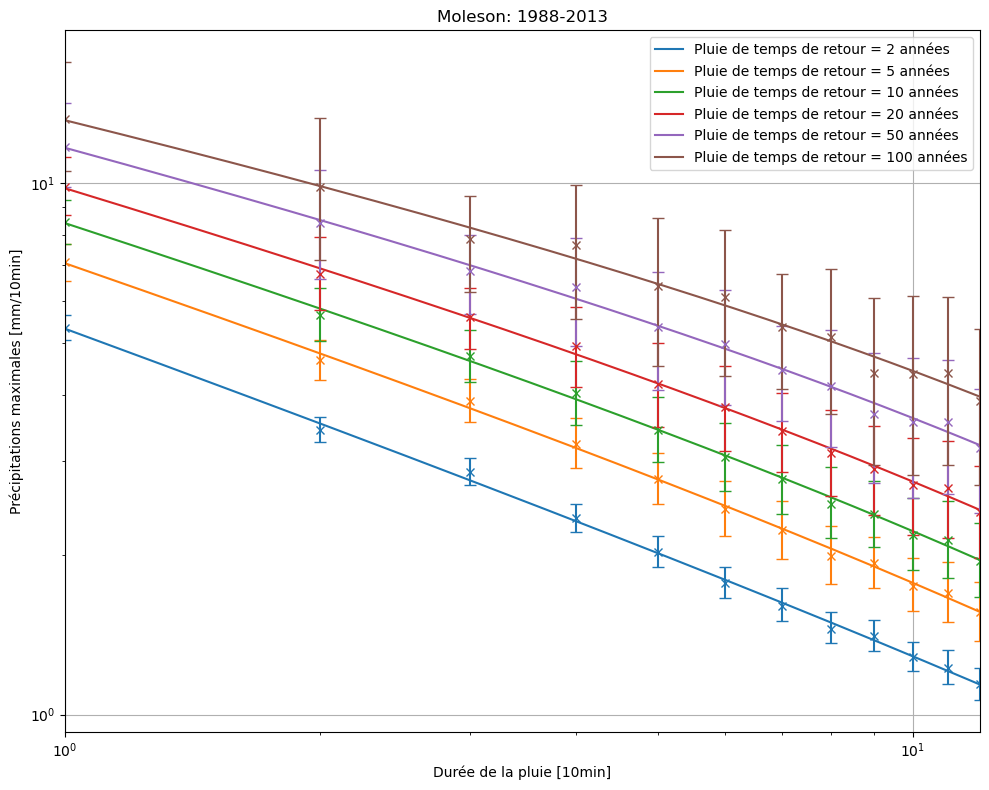

In [ ]:
j = 6

plt.figure(figsize=(10,8))
plt.subplot()
for i, t in enumerate(T):
    p1, = plt.plot(np.linspace(N[0],N[-1],1000), montana_complexe(a[j,i],b[j,i],n[j,i],np.linspace(N[0],N[-1],1000)), '-', label=f'Pluie de temps de retour = {t} années')
    color = p1.get_color()
    freq_err = np.array([Frequencies[j,:,i]-lower_quantile[j,:,i],upper_quantile[j,:,i]-Frequencies[j,:,i]],dtype=float)
    plt.errorbar(N, Frequencies[j,:,i],yerr=freq_err,fmt='x', color=color, capsize=4)
plt.xlabel('Durée de la pluie [10min]')
plt.ylabel('Précipitations maximales [mm/10min]')
plt.title(Station[num_sta]+f': {first_year+j}-{first_year+j+width_mobile}')
plt.xscale('log')
plt.yscale('log')
plt.xlim(N[0],N[-1])
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Analyse des courbes en fonction de la tranche d'années

Fonction qui définis l'écart moyen entre les courbes, le paramètre précision permet de calculer l'écart en plus ou moins de points

In [76]:
def curves_diff(i1,i2,agg,precision):
    N = np.arange(agg[0],agg[-1],precision)
    mtn1 = montana_complexe_2D(a[:,i1],b[:,i1],n[:,i1],N)
    mtn2 = montana_complexe_2D(a[:,i2],b[:,i2],n[:,i2],N)
    return np.sum(mtn2 - mtn1, axis=1) / len(N)

Ensemble des plots d'interets: Le premier représente l'écart entre les courbes (par rapport à la i1-ème courbe), les suivant représentent les paramètres du fit des courbes IDF, et le dernier représente l'intensité du k-ème point de l'IDF.

2
5
10
20
50
100


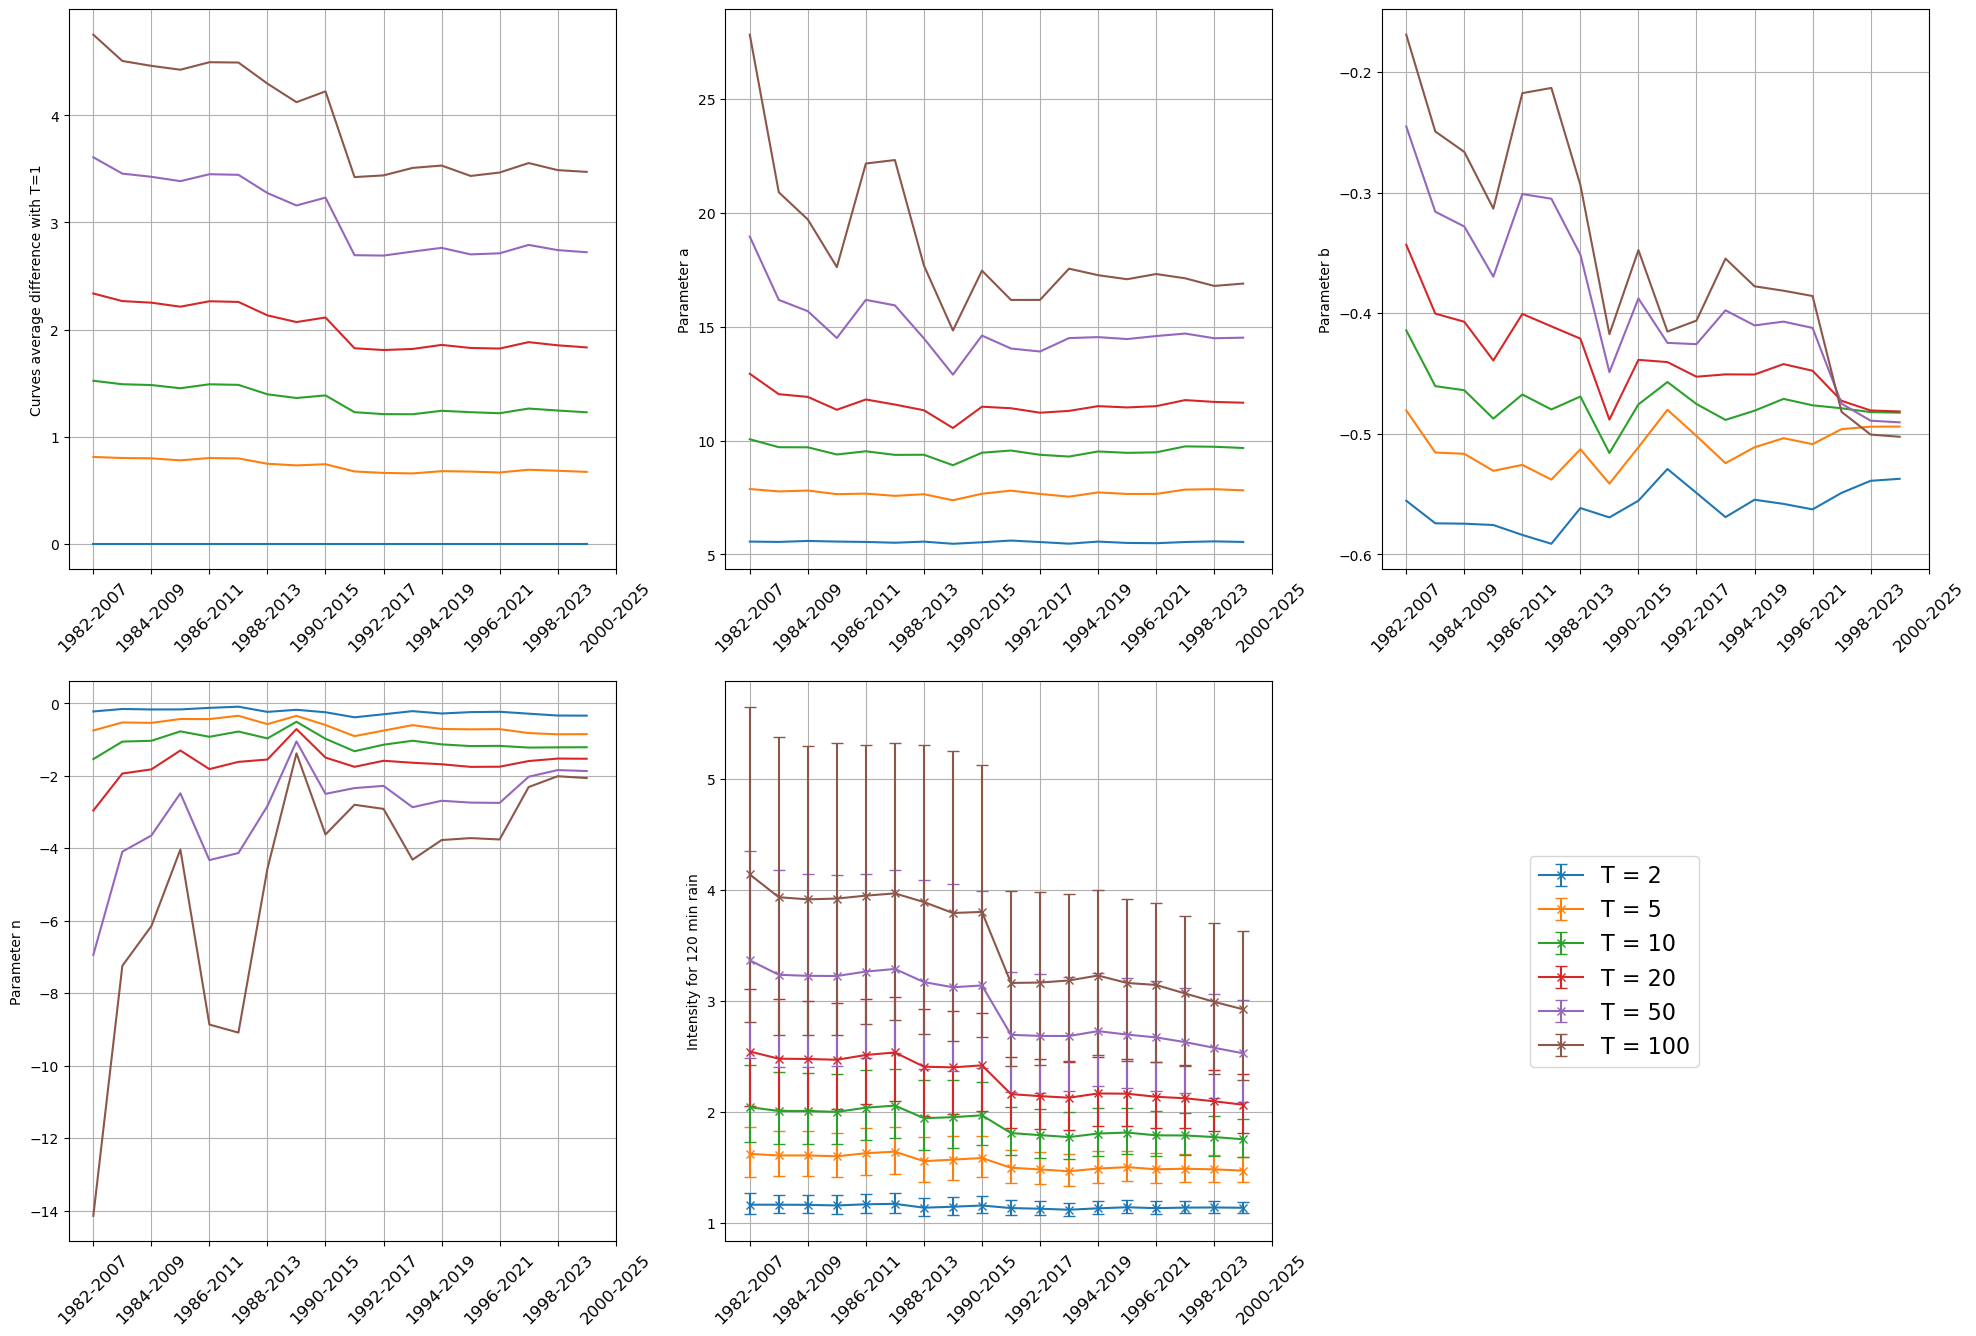

In [77]:
i1 = 0
k=11
x_labels = [f"{first_year+2*i}-{first_year+2*i+width_mobile}" for i in range(num_mobiles//2+1)]

plt.figure(figsize=(24, 16))

for i, t in enumerate(T):
    print(t)
    plt.subplot(2,3,1)
    plt.plot(1981+np.arange(num_mobiles),curves_diff(i1,i,N,0.01), label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Curves average difference with T=1')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,2)
    plt.plot(1981+np.arange(num_mobiles),a[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter a')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,3)
    plt.plot(1981+np.arange(num_mobiles),b[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter b')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    plt.subplot(2,3,4)
    plt.plot(1981+np.arange(num_mobiles),n[:,i], label=f'T = {t}')
    plt.grid('on')
    plt.ylabel('Parameter n')
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)

    freq_err = np.array([Frequencies[:,k,i]-lower_quantile[:,k,i],upper_quantile[:,k,i]-Frequencies[:,k,i]],dtype=float)

    plt.subplot(2,3,5)
    plt.errorbar(1981+np.arange(num_mobiles), Frequencies[:,k,i], yerr=freq_err, fmt='x-', capsize=4, label=f'T = {t}')
    plt.grid('on')
    plt.ylabel(f'Intensity for {(k+1)*10} min rain')
    plt.legend(loc='center right', bbox_to_anchor=(1.8,0.5), fontsize=16)
    plt.xticks(1981+np.arange(0,num_mobiles+1,2), x_labels, rotation=45, fontsize=12)